# Purity and excitation probability comparison

We will use a square wavepacket and compare markovian and wavepacket evolution.

Note:

3dB of squeezing is $r \approx 0.31$


4.5dB of squeezing is $r \approx 0.51$



In [1]:
#plt.style.use('../../../../jupyter/research-notebooks/website.mplstyle')

In [3]:
from functools import partial
import pickle
import numpy as np
from scipy.integrate import quad

from tqdm import tqdm_notebook

import pysme.hierarchy as hier
import pysme.integrate as integ

import matplotlib.pyplot as plt
import matplotlib
# #from quantum_utilities.qubits import Id, sigm, sigz, zero

In [4]:
# Define Lowering operator and Sigma Z

Id = np.eye(2, dtype=complex)

zero = np.zeros((2,2), dtype=complex)

sigz = np.array([[1, 0], [0, -1]], dtype=complex)

sigx = np.array([[0, 1], [1, 0]], dtype=complex)

sigy = np.array([[0, -1j], [1j, 0]], dtype=complex)

sigm = np.array([[0, 0], [1, 0]], dtype=complex)

In [5]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

def xi_rect(t, a, b):
    return rect(t, a, b)/np.sqrt(b - a)

def xi_gau(t, Omega, ta):
    return np.power(Omega**2/(2*np.pi), 1/4) * np.exp(-Omega**2*(t - ta)**2/4)

# Match inital decay

In [6]:
# rs = np.arcsinh(np.sqrt(np.arange(5)))
# print('rs', rs)
# print('exp(rs)', np.exp(rs))
# print('sinh(rs)^2', np.sinh(rs)**2)


n_max = 22

Omega = 0 #1.21

# 3dB of squeezing  r \approx =0.31
3 / (20* np.log10(np.e))

# 4.5dB of squeezing r \approx 0.51
r = 4.5/ (20* np.log10(np.e))



r_val_wp = r 

print('r_val_wp', r_val_wp)
#r_val_bb = 0.2335848289126526

mu_val = 0

gam = 1

xi_len = 4

S = Id
L = np.sqrt(gam) * sigm
H = zero

rho0 = (Id + (sigx + sigy)/np.sqrt(2))/2 # np.array([[1, 0], [0, 0]], dtype=complex) # excited state

xi = xi_rect


times = np.linspace(0, xi_len + 2, num=xi_len*30 + 60)

r_val_wp 0.5180816459236602


In [7]:
## M and N params
M_wp = - np.exp(2j*mu_val)* np.sinh(r_val_wp) * np.cosh(r_val_wp)
N_wp = np.sinh(r_val_wp)**2

print('M = ', M_wp)
print('N = ', N_wp)

M =  (-0.6158923855077195-0j)
N =  0.2932990801245072


### Wavepacket

In [8]:
factory = hier.HierarchyIntegratorFactory(2, n_max)
           
integrators = factory.make_uncond_integrator(partial(xi, a=0, b=xi_len), S, L, H, r=r_val_wp, mu=mu_val)

In [9]:
solns = integrators.integrate(rho0, times)

In [10]:
def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

### Vacuum evolution

In [11]:
vac_integrator_object = integ.UncondLindbladIntegrator([L],H)
vac_soln = vac_integrator_object.integrate(rho0, times)

### Markovian Squeezed evolution

here we numerically optimize over the squeeze parameter to match the inital decay of the wavepacket solution

In [12]:
# Wavepacket shape
# TODO: make wavepacket return to vac soln after x>b: f1-> 1 & f2 -> 0
def f1(x, a, b, mu, r):
    return np.cosh(r)*np.where(x < a, 0, np.where(x < b, 1, 0))

def f2(x, a, b, mu, r):
    return np.exp(2j*mu)* np.sinh(r)*np.where(x < a, 0, np.where(x < b, 1, 0))


#fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
#fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)

#L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]
#H_list = [H]

#broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
#markov_soln = broadband_integrator_object.integrate(rho0, times)

find squeezing amount to match the decay curve over the first 1 unit of time of the wavepacket

In [13]:
stz = 0.0
stp = 1.01
print('the index of t='+str(stz)+' is ', np.argmin((times-stz)**2))
print('the index of t='+str(stp)+' is ', np.argmin((times-stp)**2))

startz = np.argmin((times-stz)**2)
endz = np.argmin((times-stp)**2)
tp = times[startz:endz]
x_wp = solns.get_expectations(sigx, vac_rho(n_max))
y_wp = solns.get_expectations(sigy, vac_rho(n_max))
z_wp = solns.get_expectations(sigz, vac_rho(n_max))
xwp = x_wp[startz:endz]
ywp = y_wp[startz:endz]
zwp = z_wp[startz:endz]


def func(r_val_bb, *params):
    times, L, H, xi_len, mu_val, rho0 , xwp, ywp, zwp, startz, endz = params
    fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
    fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
    L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]
    H_list = [H]
    broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
    markov_soln = broadband_integrator_object.integrate(rho0, times)
    x_m = markov_soln.get_expectations(sigx)
    y_m = markov_soln.get_expectations(sigy)
    z_m = (markov_soln.get_expectations(sigz) + 1)/2
    xm = x_m[startz:endz]
    ym = y_m[startz:endz]
    zm = z_m[startz:endz]
    return np.sum( (ywp - ym)**2) + np.sum( (xwp - xm)**2)

the index of t=0.0 is  0
the index of t=1.01 is  30


In [14]:
from scipy import optimize
paramz = (times, L, H, xi_len, mu_val, rho0, xwp, ywp, zwp, startz, endz)
rangez = (0.0001,0.53)

soln = optimize.minimize_scalar(func, bracket=None, bounds=rangez, args=paramz)

print(soln)

r_val_bb = soln.x

     fun: 0.009175521394508614
    nfev: 19
     nit: 15
 success: True
       x: 0.09570808577932297


simulate markovian squeezed evolution with  numercially found optimal amount of squeezing

In [15]:
fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]
H_list = [H]
broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
markov_soln = broadband_integrator_object.integrate(rho0, times)
x_m = markov_soln.get_expectations(sigx)
y_m = markov_soln.get_expectations(sigy)
z_m = markov_soln.get_expectations(sigz)
xm = x_m[startz:endz]
ym = y_m[startz:endz]
zm = z_m[startz:endz]

In [16]:
ones = 0.7071067811865475*np.ones_like(xm)
zeros = np.zeros_like(xm)

### Yeoman Barnett Quasi Markovain

In [17]:
def lam_mu(gamma_c, eps):
    lam = gamma_c + eps
    mu = gamma_c - eps
    return lam, mu

def N_degen_PA(omega, omega_A, lam, mu):
    return (lam**2 - mu**2)/4*(1/((omega - omega_A)**2 + mu**2)
                               - 1/((omega - omega_A)**2 + lam**2))
    
def mod_M_degen_PA(omega, omega_A, lam, mu):
    return (lam**2 - mu**2)/4*(1/((omega - omega_A)**2 + mu**2)
                               + 1/((omega - omega_A)**2 + lam**2))

def deltas_degen_PA(gamma_c, Omega, lam, mu):
    delta_mu = gamma_c*Omega*(lam**2 - mu**2)/(4*mu*(Omega**2 + mu**2))
    delta_lam = gamma_c*Omega*(lam**2 - mu**2)/(4*lam*(Omega**2 + mu**2))
    return delta_mu, delta_lam

def F_G(delta_mu, delta_lam, Phi):
    F_A = -(1j/4)*(delta_mu*(1 + np.cos(Phi))
                   - delta_lam*(1 - np.cos(Phi)))
    G_A = -(1/4)*(delta_mu + delta_lam)*np.sin(Phi)
    return F_A, G_A

def get_degen_PA_params(Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s):
    lam, mu = lam_mu(gamma_c, eps)
    N_A = N_degen_PA(omega_A, omega_A, lam, mu)
    N_Om = N_degen_PA(omega_A + Omega, omega_A, lam, mu)
    mod_M_A = mod_M_degen_PA(omega_A, omega_A, lam, mu)
    mod_M_Om = mod_M_degen_PA(omega_A + Omega, omega_A, lam, mu)
    M_A = np.exp(2j*phi_s)*mod_M_A
    M_Om = np.exp(2j*phi_s)*mod_M_Om
    Delta_AL = omega_A - omega_L
    Phi = 2*phi_L - phi_s
    delta_mu, delta_lam = deltas_degen_PA(gamma_c, Omega, lam, mu)
    F_A, G_A = F_G(delta_mu, delta_lam, Phi)
    return N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A

In [18]:
def xi_rect(t, a, b):
    return rect(t, a, b)/np.sqrt(b - a)

In [53]:
stz = 0.0
stp = 1.01
print('the index of t='+str(stz)+' is ', np.argmin((times-stz)**2))
print('the index of t='+str(stp)+' is ', np.argmin((times-stp)**2))

startz = np.argmin((times-stz)**2)
endz = np.argmin((times-stp)**2)
tp = times[startz:endz]
x_wp = solns.get_expectations(sigx, vac_rho(n_max))
y_wp = solns.get_expectations(sigy, vac_rho(n_max))
z_wp = solns.get_expectations(sigz, vac_rho(n_max))
xwp = x_wp[startz:endz]
ywp = y_wp[startz:endz]
zwp = z_wp[startz:endz]


def funcq(x, *params):
    gamma_c, eps = x
    times, gamma, rho0 , xwp, ywp, zwp, startz, endz, Omega, omega_A, omega_L, phi_L, phi_s = params
    N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A = get_degen_PA_params(Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s)
    quasi_integrator = integ.QuasiMarkoff2LvlIntegrator(gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A)   
    quasi_soln = quasi_integrator.integrate(rho0, times)
    x_q = quasi_soln.get_expectations(sigx)
    y_q = quasi_soln.get_expectations(sigy)
    z_q = (quasi_soln.get_expectations(sigz) + 1)/2
    xq = x_q[startz:endz]
    yq = y_q[startz:endz]
    zq = z_q[startz:endz]
    return np.sum( (ywp - yq)**2) + np.sum( (xwp - xq)**2)

the index of t=0.0 is  0
the index of t=1.01 is  30


In [54]:
from scipy import optimize

Omega = 0 #2*np.abs(beta) # rabi freq
phi_L = 0 #np.angle(beta) # laser phase
omega_A = 0 # atomic transition freq
omega_L = 0 # laser freq
gamma = gam
phi_s = 0
paramz = (times, gamma, rho0 , xwp, ywp, zwp, startz, endz, Omega, omega_A, omega_L, phi_L, phi_s)

ggamma_c = 4.04
geps = 0.193

bnds = ((0, 20), (-10, 10))

solnz = optimize.minimize(funcq, args=paramz,  x0=np.array([ggamma_c, geps]), method='Nelder-Mead')#,bounds=bnds)

print(solnz)



 final_simplex: (array([[48.54344775, -2.32122859],
       [48.54338987, -2.32122582],
       [48.54341585, -2.32122707]]), array([0.00917552, 0.00917552, 0.00917552]))
           fun: 0.009175521394508505
       message: 'Optimization terminated successfully.'
          nfev: 134
           nit: 65
        status: 0
       success: True
             x: array([48.54344775, -2.32122859])


In [55]:
gamma_c = solnz.x[0]/280
eps = solnz.x[1]/180
times, gamma, rho0 , xwp, ywp, zwp, startz, endz, Omega, omega_A, omega_L, phi_L, phi_s = paramz
N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A = get_degen_PA_params(Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s)
quasi_integrator = integ.QuasiMarkoff2LvlIntegrator(gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A)   
quasi_soln = quasi_integrator.integrate(rho0, times)
x_q = quasi_soln.get_expectations(sigx)
y_q = quasi_soln.get_expectations(sigy)
z_q = (quasi_soln.get_expectations(sigz) + 1)/2

xq = x_q[startz:endz]
yq = y_q[startz:endz]
zq = z_q[startz:endz]

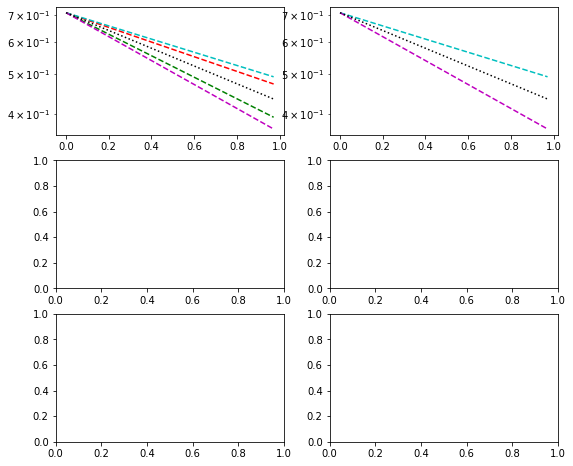

In [56]:

fig, axs = plt.subplots(nrows=3,ncols=2, figsize=(9, 8), sharey=False)

axs[0,0].semilogy(times[startz:endz], xm, label='X M',linestyle='--',color='r')
axs[0,0].semilogy(times[startz:endz], ym, label='Y M',linestyle='--',color='g')
axs[0,0].semilogy(times[startz:endz], xq, label='X M',linestyle='--',color='c')
axs[0,0].semilogy(times[startz:endz], yq, label='Y M',linestyle='--',color='m')
axs[0,0].semilogy(times[startz:endz], vac_soln.get_expectations(sigy)[startz:endz], label='X & Y vac',linestyle=':',color='k')
axs[0,1].semilogy(times[startz:endz], xq, label='X M',linestyle='--',color='c')
axs[0,1].semilogy(times[startz:endz], yq, label='Y M',linestyle='--',color='m')
axs[0,1].semilogy(times[startz:endz], vac_soln.get_expectations(sigy)[startz:endz], label='X & Y vac',linestyle=':',color='k')

In [58]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

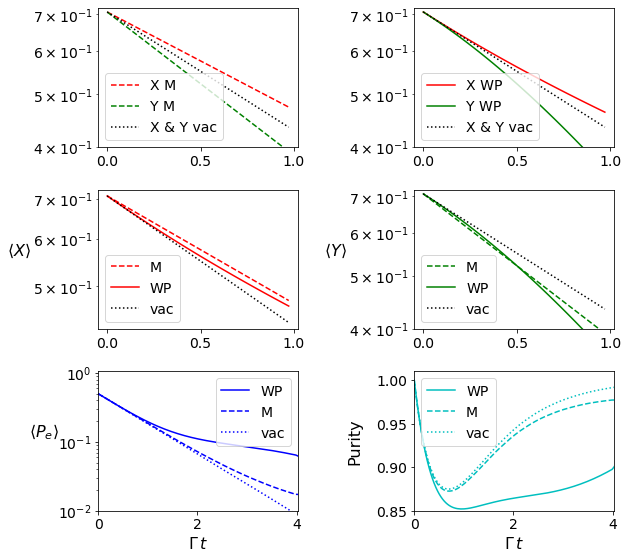

In [110]:

fig, axs = plt.subplots(nrows=3,ncols=2, figsize=(9, 8), sharey=False)

axs[0,0].semilogy(times[startz:endz], xm, label='X M',linestyle='--',color='r')
axs[0,0].semilogy(times[startz:endz], ym, label='Y M',linestyle='--',color='g')
axs[0,0].semilogy(times[startz:endz], vac_soln.get_expectations(sigy)[startz:endz], label='X & Y vac',linestyle=':',color='k')
#axs[1].set_ylabel(r'$\langle Y \rangle$',rotation=0,labelpad=14)
#axs[0,0].set_title('Markovian')
axs[0,0].set_ylim([4e-1,7.2e-1])
axs[0,0].legend()
axs[0,1].semilogy(times[startz:endz], xwp, label='X WP',linestyle='-',color='r')
axs[0,1].semilogy(times[startz:endz], ywp, label='Y WP',linestyle='-',color='g')
axs[0,1].semilogy(times[startz:endz], vac_soln.get_expectations(sigx)[startz:endz], label='X & Y vac',linestyle=':',color='k')
#axs[0].set_ylabel(r'',rotation=0,labelpad=14)
axs[0,1].set_ylim([4e-1,7.2e-1])
#axs[0,1].set_title('Wave packet')
axs[0,1].legend()



axs[1,1].semilogy(times[startz:endz], ym, label='M',linestyle='--',color='g')
axs[1,1].semilogy(times[startz:endz], ywp, label='WP',linestyle='-',color='g')
axs[1,1].semilogy(times[startz:endz], vac_soln.get_expectations(sigy)[startz:endz], label='vac',linestyle=':',color='k')
axs[1,1].set_ylabel(r'$\langle Y \rangle$',rotation=0,labelpad=14)
axs[1,1].set_ylim([4e-1,7.2e-1])
axs[1,1].legend()
axs[1,0].semilogy(times[startz:endz], xm, label='M',linestyle='--',color='r')
axs[1,0].semilogy(times[startz:endz], xwp, label='WP',linestyle='-',color='r')
axs[1,0].semilogy(times[startz:endz], vac_soln.get_expectations(sigx)[startz:endz], label='vac',linestyle=':',color='k')
axs[1,0].set_ylabel(r'$\langle X \rangle$',rotation=0,labelpad=14)
#axs[0,1].set_ylim([4e-1,7.2e-1])
#axs[0].set_yticks(minor=True)
axs[1,0].legend()



# asdf




rwp_plot = np.round(r_val_wp,3)
rbb_plot = np.round(r_val_bb,3)

#axs[2,0].plot(times, xi_rect(times,a=0, b=xi_len),label=r'$\xi(t)$',linestyle='--',color='k')
axs[2,0].semilogy(times, (solns.get_expectations(sigz, vac_rho(n_max)) + 1)/2,label='WP',linestyle='-',color='b')
axs[2,0].semilogy(times, (markov_soln.get_expectations(sigz) + 1)/2, label='M',linestyle='--',color='b')
axs[2,0].semilogy(times, (vac_soln.get_expectations(sigz) + 1)/2, label='vac',linestyle=':',color='b')
#axs[0].set_yscale('log')
axs[2,0].set_xlim(0.0, 4.025)
axs[2,0].set_ylim(1e-2, 1.05) 
axs[2,0].set_ylabel(r'$\langle P_e \rangle $',rotation=0,labelpad=14) 
axs[2,0].set_xlabel(r'$\Gamma\, t $')
axs[2,0].legend()

#axs[2,1].plot(times, solns.get_purities(vac_rho(n_max)),label='WP r =' + str(rwp_plot),linestyle='-',color='c')
#axs[2,1].plot(times, markov_soln.get_purities(),label='Markov r = ' + str(rbb_plot), linestyle='--',color='c')
axs[2,1].plot(times, solns.get_purities(vac_rho(n_max)),label='WP',linestyle='-',color='c')
axs[2,1].plot(times, markov_soln.get_purities(),label='M', linestyle='--',color='c')
axs[2,1].plot(times, vac_soln.get_purities(),label='vac',linestyle=':',color='c')
#f3_ax2.set_yscale('log')
axs[2,1].set_xlim(0.0, 4.025)
axs[2,1].set_ylim(0.85, 1.01) 
axs[2,1].set_xlabel(r'$\Gamma\, t $')
axs[2,1].set_ylabel(r'Purity',labelpad=14)
axs[2,1].legend()#loc='upper left')


plt.tight_layout()

name='wp_v_markov_cmp'
plt.savefig(name+'.pdf',bbox_inches = 'tight', pad_inches = 0.02)

In [111]:
r_val_bb


0.09570808577932297

In [56]:
# fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
# fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)

# L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]

# H_list = [H]

# broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
# markov_soln = broadband_integrator_object.integrate(rho0, times)

In [57]:
#M and N params
M = - np.exp(2j*mu_val)* np.sinh(r_val_bb) * np.cosh(r_val_bb)
N = np.sinh(r_val_bb)**2

print(N,M)
print(N+M+1/2)
print(N-M+1/2)

0.009188040628679658 (-0.09629361723018783-0j)
(0.4128944233984918+0j)
(0.6054816578588675+0j)


In [58]:
# expected modification of decay rate relative to vac
2*N+1


1.0183760812573592

In [114]:
np.exp(r_val_bb)
np.exp(-r_val_bb)


0.9087292483446231

# Match steady state exitation probablity

In [115]:
# rs = np.arcsinh(np.sqrt(np.arange(5)))
# print('rs', rs)
# print('exp(rs)', np.exp(rs))
# print('sinh(rs)^2', np.sinh(rs)**2)


n_max = 22

Omega = 0 #1.21

# 3dB of squeezing  r \approx =0.31
3 / (20* np.log10(np.e))

# 4.5dB of squeezing r \approx 0.51
r = 4.5/ (20* np.log10(np.e))



r_val_wp = r 

#r_val_bb = 0.2335848289126526

mu_val = 0

gam = 1

xi_len = 9


S = Id
L = np.sqrt(gam) * sigm
H = zero


rho0 = (Id + (sigx + sigy)/np.sqrt(2))/2
#np.array([[1, 0], [0, 0]], dtype=complex) # excited state
#

xi = xi_rect



times = np.linspace(0, xi_len + 2, num=xi_len*30 + 60)



In [116]:
print(np.trace(rho0@sigx))
print(np.trace(rho0@sigy))
print(np.trace(rho0@sigz))

(0.7071067811865475+0j)
(0.7071067811865475+0j)
0j


In [117]:
# wavepacket 

factory = hier.HierarchyIntegratorFactory(2, n_max)
           
integrators = factory.make_uncond_integrator(partial(xi, a=0, b=xi_len), S, L, H, r=r_val_wp, mu=mu_val)

solns = integrators.integrate(rho0, times)

In [118]:
# vaccum
vac_integrator_object = integ.UncondLindbladIntegrator([L],H)
vac_soln = vac_integrator_object.integrate(rho0, times)

In [119]:
stz = 5.0
stp = 9.0
print('the index of t='+str(stz)+' is ', np.argmin((times-stz)**2))
print('the index of t='+str(stp)+' is ', np.argmin((times-stp)**2))

startz = np.argmin((times-stz)**2)
endz = np.argmin((times-stp)**2)
tp = times[startz:endz]
x_wp = solns.get_expectations(sigx, vac_rho(n_max))
y_wp = solns.get_expectations(sigy, vac_rho(n_max))
z_wp = solns.get_expectations(sigz, vac_rho(n_max))
xwp = x_wp[startz:endz]
ywp = y_wp[startz:endz]
zwp = (z_wp[startz:endz]+1)/2


def func(r_val_bb, *params):
    times, L, H, xi_len, mu_val, rho0 , xwp, ywp, zwp, startz, endz = params
    fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
    fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
    L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]
    H_list = [H]
    broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
    markov_soln = broadband_integrator_object.integrate(rho0, times)
    x_m = markov_soln.get_expectations(sigx)
    y_m = markov_soln.get_expectations(sigy)
    z_m = (markov_soln.get_expectations(sigz) + 1)/2
    xm = x_m[startz:endz]
    ym = y_m[startz:endz]
    zm = z_m[startz:endz]
    return np.sum( (zwp - zm)**2)

the index of t=5.0 is  150
the index of t=9.0 is  269


In [120]:
from scipy import optimize
paramz = (times, L, H, xi_len, mu_val, rho0, xwp, ywp, zwp, startz, endz)
rangez = (0.0001,0.53)

soln = optimize.minimize_scalar(func, bracket=None, bounds=rangez, args=paramz)

print(soln)

r_val_bb = soln.x

     fun: 0.0027187948894989307
    nfev: 18
     nit: 14
 success: True
       x: 0.21411470432227903


In [121]:
fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)

L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]

H_list = [H]

broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
markov_soln = broadband_integrator_object.integrate(rho0, times)

In [122]:
x_m = markov_soln.get_expectations(sigx)
y_m = markov_soln.get_expectations(sigy)
z_m = (markov_soln.get_expectations(sigz) + 1)/2

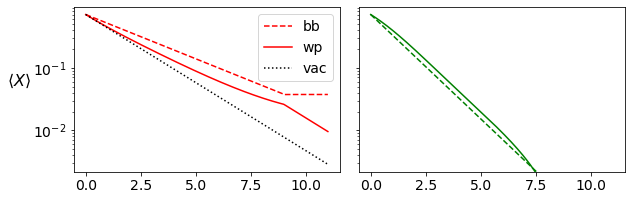

In [123]:

fig, axs = plt.subplots(ncols=2, figsize=(9, 3), sharey=True)
axs[0].semilogy(times, x_m, label='bb',linestyle='--',color='r')
axs[0].semilogy(times, x_wp, label='wp',linestyle='-',color='r')
axs[0].semilogy(times, vac_soln.get_expectations(sigx), label='vac',linestyle=':',color='k')
axs[0].set_ylabel(r'$\langle X \rangle$',rotation=0,labelpad=14)
#axs[0].set_ylim([4e-1,7.2e-1])
#axs[0].set_yticks(minor=True)
axs[0].legend()
axs[1].semilogy(times, y_m, label='bb',linestyle='--',color='g')
axs[1].semilogy(times, y_wp, label='wp',linestyle='-',color='g')
# axs[1].semilogy(times[startz:endz], vac_soln.get_expectations(sigy)[startz:endz], label='vac',linestyle=':',color='k')
# axs[1].set_ylabel(r'$\langle Y \rangle$',rotation=0,labelpad=14)
# axs[1].set_ylim([4e-1,7.2e-1])
# axs[1].legend()


plt.tight_layout()
name='bloch_cmp'
plt.savefig(name+'.pdf',bbox_inches = 'tight', pad_inches = 0.02)

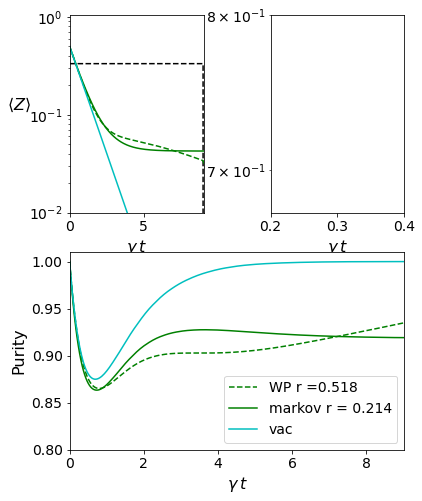

In [124]:
gs = matplotlib.gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=[6, 8])

gs = fig.add_gridspec(ncols=2, nrows=2,wspace=0.5)


f3_ax0 = fig.add_subplot(gs[0, :-1])
f3_ax1 = fig.add_subplot(gs[0, 1])
f3_ax2 = fig.add_subplot(gs[1, :])


rwp_plot = np.round(r_val_wp,3)
rbb_plot = np.round(r_val_bb,3)

f3_ax0.plot(times, xi_rect(times,a=0, b=xi_len),label='WP',linestyle='--',color='k')
f3_ax0.plot(times, (solns.get_expectations(sigz, vac_rho(n_max)) + 1)/2,label='Z wp',linestyle='--',color='g')
f3_ax0.plot(times, (markov_soln.get_expectations(sigz) + 1)/2, label='Z markov',linestyle='-',color='g')
f3_ax0.plot(times, (vac_soln.get_expectations(sigz) + 1)/2, label='Z vac',linestyle='-',color='c')
f3_ax0.set_yscale('log')
f3_ax0.set_xlim(0.0, 9.025)
f3_ax0.set_ylim(1e-2, 1.05) 
f3_ax0.set_ylabel(r'$\langle Z \rangle $',rotation=0,labelpad=10) 
f3_ax0.set_xlabel(r'$\gamma\, t $')



f3_ax1.plot(times, xi_rect(times,a=0, b=xi_len),label='WP',linestyle='--',color='k')
f3_ax1.plot(times, (solns.get_expectations(sigz, vac_rho(n_max)) + 1)/2,label='Z wp',linestyle='--',color='g')
f3_ax1.plot(times, (markov_soln.get_expectations(sigz) + 1)/2, label='Z markov',linestyle='-',color='g')
f3_ax1.plot(times, (vac_soln.get_expectations(sigz) + 1)/2, label='Z vac',linestyle='-',color='c')
f3_ax1.set_yscale('log')
f3_ax1.set_xlim(0.2, 0.4)
f3_ax1.set_ylim(6.75e-1, 8e-1) 
f3_ax1.set_xlabel(r'$\gamma\, t $')



f3_ax2.plot(times, solns.get_purities(vac_rho(n_max)),label='WP r =' + str(rwp_plot),linestyle='--',color='g')
f3_ax2.plot(times, markov_soln.get_purities(),label='markov r = ' + str(rbb_plot), linestyle='-',color='g')
f3_ax2.plot(times, vac_soln.get_purities(),label='vac',linestyle='-',color='c')
#f3_ax2.set_yscale('log')
f3_ax2.set_xlim(0.0, 9.025)
f3_ax2.set_ylim(0.8, 1.01) 
f3_ax2.set_xlabel(r'$\gamma\, t $')
f3_ax2.set_ylabel(r'Purity',labelpad=5)
f3_ax2.legend()


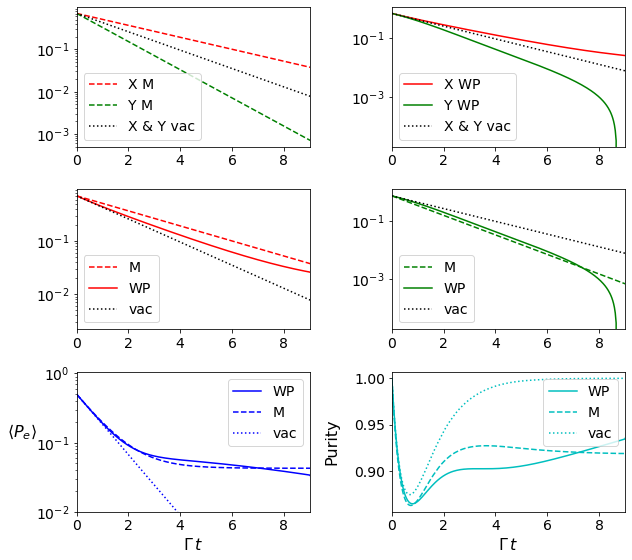

In [159]:

fig, axs = plt.subplots(nrows=3,ncols=2, figsize=(9, 8), sharey=False)

axs[0,0].semilogy(times, markov_soln.get_expectations(sigx), label='X M',linestyle='--',color='r')
axs[0,0].semilogy(times, markov_soln.get_expectations(sigy), label='Y M',linestyle='--',color='g')
axs[0,0].semilogy(times, vac_soln.get_expectations(sigy), label='X & Y vac',linestyle=':',color='k')
#axs[1].set_ylabel(r'$\langle Y \rangle$',rotation=0,labelpad=14)
#axs[0,0].set_title('Markovian')
axs[0,0].set_xlim([0,9])
axs[0,0].legend()
axs[0,1].semilogy(times, solns.get_expectations(sigx, vac_rho(n_max)), label='X WP',linestyle='-',color='r')
axs[0,1].semilogy(times, solns.get_expectations(sigy, vac_rho(n_max)), label='Y WP',linestyle='-',color='g')
axs[0,1].semilogy(times, vac_soln.get_expectations(sigx), label='X & Y vac',linestyle=':',color='k')
axs[0,1].set_xlim([0,9])
#axs[0].set_ylabel(r'',rotation=0,labelpad=14)
#axs[0,1].set_ylim([4e-1,7.2e-1])
#axs[0,1].set_title('Wave packet')
axs[0,1].legend()



axs[1,1].semilogy(times, markov_soln.get_expectations(sigy), label='M',linestyle='--',color='g')
axs[1,1].semilogy(times, solns.get_expectations(sigy, vac_rho(n_max)), label='WP',linestyle='-',color='g')
axs[1,1].semilogy(times, vac_soln.get_expectations(sigy), label='vac',linestyle=':',color='k')
# axs[1,1].set_ylabel(r'$\langle Y \rangle$',rotation=0,labelpad=14)
# axs[1,1].set_ylim([4e-1,7.2e-1])
axs[1,1].set_xlim([0,9])
axs[1,1].legend()
axs[1,0].semilogy(times, markov_soln.get_expectations(sigx), label='M',linestyle='--',color='r')
axs[1,0].semilogy(times, solns.get_expectations(sigx, vac_rho(n_max)), label='WP',linestyle='-',color='r')
axs[1,0].semilogy(times, vac_soln.get_expectations(sigx), label='vac',linestyle=':',color='k')
axs[1,0].set_xlim([0,9])
# axs[1,0].set_ylabel(r'$\langle X \rangle$',rotation=0,labelpad=14)
# #axs[0,1].set_ylim([4e-1,7.2e-1])
# #axs[0].set_yticks(minor=True)
axs[1,0].legend()



# # asdf




# rwp_plot = np.round(r_val_wp,3)
# rbb_plot = np.round(r_val_bb,3)

# #axs[2,0].plot(times, xi_rect(times,a=0, b=xi_len),label=r'$\xi(t)$',linestyle='--',color='k')
axs[2,0].semilogy(times, (solns.get_expectations(sigz, vac_rho(n_max)) + 1)/2,label='WP',linestyle='-',color='b')
axs[2,0].semilogy(times, (markov_soln.get_expectations(sigz) + 1)/2, label='M',linestyle='--',color='b')
axs[2,0].semilogy(times, (vac_soln.get_expectations(sigz) + 1)/2, label='vac',linestyle=':',color='b')
axs[2,0].set_xlim([0,9])
# #axs[0].set_yscale('log')
axs[2,0].set_ylim(1e-2, 1.05) 
axs[2,0].set_ylabel(r'$\langle P_e \rangle $',rotation=0,labelpad=14) 
axs[2,0].set_xlabel(r'$\Gamma\, t $')
axs[2,0].legend()

# #axs[2,1].plot(times, solns.get_purities(vac_rho(n_max)),label='WP r =' + str(rwp_plot),linestyle='-',color='c')
axs[2,1].plot(times, solns.get_purities(vac_rho(n_max)),label='WP',linestyle='-',color='c')
axs[2,1].plot(times, markov_soln.get_purities(),label='M', linestyle='--',color='c')
axs[2,1].plot(times, vac_soln.get_purities(),label='vac',linestyle=':',color='c')
axs[2,1].set_xlim([0,9])
# #f3_ax2.set_yscale('log')
# axs[2,1].set_xlim(0.0, 4.025)
# axs[2,1].set_ylim(0.85, 1.01) 
axs[2,1].set_xlabel(r'$\Gamma\, t $')
axs[2,1].set_ylabel(r'Purity',labelpad=14)
axs[2,1].legend()#loc='upper left')


plt.tight_layout()

name='wp_v_markov_cmp_exitation'
plt.savefig(name+'.pdf',bbox_inches = 'tight', pad_inches = 0.02)

In [160]:
r_val_bb

0.21411470432227903